# Explainable AI

## Worksheet 2: Counterfactuals
---


---
### What are counterfactuals?

Counterfactuals provide local explantions to indiviudal observations. Counterfactuals identity the minimum changes an observation would need to undertake inorder to change a given model's prediction. For further information on the topic and definitions, we refer students to the lecture slides and recordings for the XAI technique (Counterfactuals).


Useful sources:

*   https://christophm.github.io/interpretable-ml-book/counterfactual.html
*   https://docs.seldon.io/projects/alibi/en/stable/index.html



---

---

### Today's problem


In the second tutorial, we will look at applications of counterfactuals.

There are many libraries which try to introduce counterfactuals in Python. Firstly, there is DiCE (Diverse Counterfactual Explanations) that you can find [here](https://https://github.com/interpretml/DiCE) which has been based on a research paper outlined in [this](https://https://www.microsoft.com/en-us/research/blog/open-source-library-provides-explanation-for-machine-learning-through-diverse-counterfactuals/) blogpost. However, at the moment, it only works with selected TensorFlow/PyTorch models.

Secondly, [CEML](https://ceml.readthedocs.io/en/latest/) could be another choice. One limitation of it, though, is that it only allows you to explain a rather narrow array of models such as basic scikit-learn implementations.

Thirdly, we could also leverage the counterfactual methods contained inside the [Alibi](https://docs.seldon.io/projects/alibi/en/latest/) package. Unfortunately, the API is quite complex, focuses on neural networks and, in practice, can return awkward errors instead of desired outputs. Despite this, this is the most universal open source framework currently available and this notebook will show you how you can successfully apply it.

We will utilise the technique within the context of stop and search practices employed by police officers in London. The exercises will look at the data provided by the Metropolitan Police and The City of London Police which can be accessed via the following [link](https://data.police.uk/data/).

Let's assume in this tutorial that the police force wants to introduce robo-police who would patrol the streets and perform stop and search operations based on a classification model. This algorithm would assume that a good outcome is one where a stopped person ends up being fined or arressted and a bad outcome is a situation where no further action is taken. The idea here is to replicate decisions of human police using historical data.

---


## Example


### Importing libraries & data

Similarly to the last work sheet, we need to install libraries, which are not by default in Google Colab.

In [1]:
!pip install alibi #==0.6.2

Now, we can import the extra functionalities from relevant Python libraries.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix #plot_confusion_matrix
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import tensorflow as tf
tf.random.set_seed(1234)
from alibi.explainers import CounterfactualProto
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import time
tf.compat.v1.random.set_random_seed(1234)
np.random.seed(1234)

Instructions for updating:
non-resource variables are not supported in the long term


To load the data, we need to connect Google colab to our google drive.

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv("/content/drive/My Drive/XAI-Worksheets/met_police.csv", sep=',')

### Data processing

Below, we will take the following steps.

*   Visually checking what we have in the DataFrame
*   Assessing and treating potential missingness
*   Creating new labels
*   Feature engineering new attributes
*   Dropping irrelevant columns

Let's start by displaying the first few lines of the DataFrame to get a general idea of our dataset.





In [5]:
df.head()

,Type,Date,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing
0,Person and Vehicle search,2020-06-30T23:00:00+00:00,False,NaN,NaN,NaN,Male,25-34,Black/African/Caribbean/Black British - Any ot...,Black,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,A no further action disposal,NaN,NaN
1,Person search,2020-06-30T23:01:00+00:00,False,NaN,51.447794,-0.188333,Male,Oct-17,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,A no further action disposal,NaN,NaN
2,Person search,2020-06-30T23:02:00+00:00,False,NaN,51.503196,-0.127032,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Articles for use in criminal damage,A no further action disposal,NaN,NaN
3,Person search,2020-06-30T23:03:00+00:00,False,NaN,51.506712,-0.126974,Male,Oct-17,White - Any other White background,White,Police and Criminal Evidence Act 1984 (section 1),Evidence of offences under the Act,A no further action disposal,NaN,NaN
4,Person search,2020-06-30T23:03:00+00:00,False,NaN,51.516701,-0.185240,Male,NaN,Other ethnic group - Not stated,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,NaN


We will need the names of the features later, so we store them separately.


In [6]:
df_col_used = df.columns.tolist()
df_col_used

['Type',
 'Date',
 'Part of a policing operation',
 'Policing operation',
 'Latitude',
 'Longitude',
 'Gender',
 'Age range',
 'Self-defined ethnicity',
 'Officer-defined ethnicity',
 'Legislation',
 'Object of search',
 'Outcome',
 'Outcome linked to object of search',
 'Removal of more than just outer clothing']

Now, let's see what the types of the features are.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3726 entries, 0 to 3725
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Type                                      3726 non-null   object 
 1   Date                                      3726 non-null   object 
 2   Part of a policing operation              3726 non-null   bool   
 3   Policing operation                        0 non-null      float64
 4   Latitude                                  3298 non-null   float64
 5   Longitude                                 3298 non-null   float64
 6   Gender                                    3670 non-null   object 
 7   Age range                                 3225 non-null   object 
 8   Self-defined ethnicity                    3671 non-null   object 
 9   Officer-defined ethnicity                 3632 non-null   object 
 10  Legislation                         

We can see that there are some missing values in our dataset. This would result in a problem for a majority of machine learning algorithms. One treatment, which will be performed below, is removing rows with missing data.

#### **Question 1:**
Name 3 other methods of treating missingness in data.

Let's start by dropping empty columns.

In [8]:
names_empty_cols = df.isna().sum()[df.isna().sum() == df.shape[0]].index.tolist()
df = df.drop(columns = names_empty_cols)

Now, let's also drop rows where any element is empty.

In [9]:
df = df.dropna()


Let's have a look at how our data looks now.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2836 entries, 1 to 3724
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Type                          2836 non-null   object 
 1   Date                          2836 non-null   object 
 2   Part of a policing operation  2836 non-null   bool   
 3   Latitude                      2836 non-null   float64
 4   Longitude                     2836 non-null   float64
 5   Gender                        2836 non-null   object 
 6   Age range                     2836 non-null   object 
 7   Self-defined ethnicity        2836 non-null   object 
 8   Officer-defined ethnicity     2836 non-null   object 
 9   Legislation                   2836 non-null   object 
 10  Object of search              2836 non-null   object 
 11  Outcome                       2836 non-null   object 
dtypes: bool(1), float64(2), object(9)
memory usage: 268.6+ KB


Looks good, we got rid of all incomplete data, and we can get the labels and store them separately. First let us analyse what is inside of the label column named `Outcome`.

In [11]:
list(set(df["Outcome"]))


['A no further action disposal',
 'Summons / charged by post',
 'Caution (simple or conditional)',
 'Penalty Notice for Disorder',
 'Arrest',
 'Community resolution']

We have six different outcomes, but we just want to have two: 1 will stand for "Further action was needed", 0 for "No further action was needed"

In [12]:
labels = [0 if x == "A no further action disposal" else 1 for x in df["Outcome"]]

Because we have stored the labels separetly we can now drop the `Outcome` column from the Dataframe.

In [13]:
outcome_name = "Outcome"
df = df.drop(columns = outcome_name)

Next, let's change the data type of "Part of a policing operation" for consistency.

In [14]:
df.loc[:, "Part of a policing operation"] = df["Part of a policing operation"].astype(str)

We also need to specify that "Date" holds our time information.

In [15]:
df.loc[:, "Date"] = pd.to_datetime(df["Date"], infer_datetime_format=True)

<ipython-input-15-a100e8e1f03c>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "Date"] = pd.to_datetime(df["Date"], infer_datetime_format=True)


Specifying this information allows us to extract some information from the `Date` column. For example, we can separate out which day of the week the stop and search occured on.

In [16]:
df['Day'] = df['Date'].dt.dayofweek


It might be of interest to also know which time the stop and search occured at.

In [17]:
time_index = df['Date'].reset_index().set_index('Date')

morning_table = time_index.between_time("5:00", "12:00").values
afternoon_table = time_index.between_time("12:01", "17:00").values
evening_table = time_index.between_time("17:01", "22:00").values

time_indicator = ["Morning" if index in morning_table
                   else "Afternoon" if index in afternoon_table
                   else "Evening" if index in evening_table
                   else "Night" for index in df.index]

df["Time_indicator"] = time_indicator

This indicator can replace the "Time" column. We are doing this to avoid a problem associated with the cyclical nature of time where 23:59 is just 1 minute away from 00:00 but for our model these two values would be on the opposite sides of the scale.

An alternative approach would be to use sin(t) and cos(t) as 2 separate variables in df (see more [here](https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca)) but this would diminish the clarity of any results.

We can now use "Date" as our index.

In [18]:
df = df.set_index("Date")
df

,Type,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Day,Time_indicator
Date,,,,,,,,,,,,
2020-06-30 23:01:00+00:00,Person search,False,51.447794,-0.188333,Male,Oct-17,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,1,Night
2020-06-30 23:02:00+00:00,Person search,False,51.503196,-0.127032,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Articles for use in criminal damage,1,Night
2020-06-30 23:03:00+00:00,Person search,False,51.506712,-0.126974,Male,Oct-17,White - Any other White background,White,Police and Criminal Evidence Act 1984 (section 1),Evidence of offences under the Act,1,Night
2020-06-30 23:05:00+00:00,Person search,False,51.445097,-0.124330,Male,25-34,Other ethnic group - Not stated,Black,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,1,Night
2020-06-30 23:20:00+00:00,Person search,False,51.492278,-0.101766,Male,18-24,White - Any other White background,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,1,Night
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-04 19:40:00+00:00,Person and Vehicle search,False,51.519920,-0.056696,Male,18-24,Asian/Asian British - Any other Asian background,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,5,Evening
2020-07-04 19:40:00+00:00,Person search,False,51.567577,-0.111517,Male,over 34,Other ethnic group - Not stated,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,5,Evening
2020-07-04 19:40:00+00:00,Person search,False,51.509725,-0.293224,Male,Oct-17,Mixed/Multiple ethnic groups - Any other Mixed...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,5,Evening


We can also process the `Age range` column and replace strings with values that reflect the relative order.

In [19]:
age_vals = list(set(df["Age range"]))
age_vals = sorted(age_vals)
age_vals

['18-24', '25-34', 'Oct-17', 'over 34', 'under 10']

We can see that the actual values should be the following: `under 10`, `10-17`, `18-24`, `25-34`, `over 34`

We can map the ranges to numbers as a way of encoding.

In [20]:
age_dict = {"under 10":1,
            "Oct-17":2,
            "18-24":3,
            "25-34":4,
            "over 34":5}

df["Age"] = df["Age range"].map(age_dict)
df = df.drop(columns = ["Age range"])
df.head()

,Type,Part of a policing operation,Latitude,Longitude,Gender,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Day,Time_indicator,Age
Date,,,,,,,,,,,,
2020-06-30 23:01:00+00:00,Person search,False,51.447794,-0.188333,Male,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,1,Night,2
2020-06-30 23:02:00+00:00,Person search,False,51.503196,-0.127032,Male,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Articles for use in criminal damage,1,Night,3
2020-06-30 23:03:00+00:00,Person search,False,51.506712,-0.126974,Male,White - Any other White background,White,Police and Criminal Evidence Act 1984 (section 1),Evidence of offences under the Act,1,Night,2
2020-06-30 23:05:00+00:00,Person search,False,51.445097,-0.124330,Male,Other ethnic group - Not stated,Black,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,1,Night,4
2020-06-30 23:20:00+00:00,Person search,False,51.492278,-0.101766,Male,White - Any other White background,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,1,Night,3


Next we want to define which columns contain numeric and which categorical data.

In [21]:
numeric_features = ["Longitude", "Latitude", "Day", "Age"]
categorical_features = list(set(df.columns.tolist()) - set(numeric_features))
categorical_features = sorted(categorical_features)

Let's keep a tidy DataFrame and reorganise the data so that the categorical features are first.

In [22]:
df = df[categorical_features + numeric_features]
df

,Gender,Legislation,Object of search,Officer-defined ethnicity,Part of a policing operation,Self-defined ethnicity,Time_indicator,Type,Longitude,Latitude,Day,Age
Date,,,,,,,,,,,,
2020-06-30 23:01:00+00:00,Male,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,White,False,White - English/Welsh/Scottish/Northern Irish/...,Night,Person search,-0.188333,51.447794,1,2
2020-06-30 23:02:00+00:00,Male,Police and Criminal Evidence Act 1984 (section 1),Articles for use in criminal damage,White,False,White - English/Welsh/Scottish/Northern Irish/...,Night,Person search,-0.127032,51.503196,1,3
2020-06-30 23:03:00+00:00,Male,Police and Criminal Evidence Act 1984 (section 1),Evidence of offences under the Act,White,False,White - Any other White background,Night,Person search,-0.126974,51.506712,1,2
2020-06-30 23:05:00+00:00,Male,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,Black,False,Other ethnic group - Not stated,Night,Person search,-0.124330,51.445097,1,4
2020-06-30 23:20:00+00:00,Male,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,White,False,White - Any other White background,Night,Person search,-0.101766,51.492278,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-04 19:40:00+00:00,Male,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Asian,False,Asian/Asian British - Any other Asian background,Evening,Person and Vehicle search,-0.056696,51.519920,5,3
2020-07-04 19:40:00+00:00,Male,Misuse of Drugs Act 1971 (section 23),Controlled drugs,White,False,Other ethnic group - Not stated,Evening,Person search,-0.111517,51.567577,5,5
2020-07-04 19:40:00+00:00,Male,Misuse of Drugs Act 1971 (section 23),Controlled drugs,White,False,Mixed/Multiple ethnic groups - Any other Mixed...,Evening,Person search,-0.293224,51.509725,5,2


To make the algorithm that generates counterfactuals more efficient, we can scale our numerical features between -1 and 1.

In [23]:
scaler = MinMaxScaler(feature_range = (-1, 1))

# We may need scaling_factors_1 and _2 if any counterfactuals are linked to numerical features
# to rescale them back.
scaling_factor_1 = []
scaling_factor_2 = []
for feature in numeric_features:
    df.loc[:, feature] = scaler.fit_transform(df[feature].to_numpy().reshape(-1, 1))
    scaling_factor_1.append(scaler.scale_)
    scaling_factor_2.append(scaler.min_)
scaling_factors_1 = dict(zip(numeric_features, scaling_factor_1))
scaling_factors_2 = dict(zip(numeric_features, scaling_factor_2))

# Let's have a look at the DataFrame with scaled numerical features.
df

,Gender,Legislation,Object of search,Officer-defined ethnicity,Part of a policing operation,Self-defined ethnicity,Time_indicator,Type,Longitude,Latitude,Day,Age
Date,,,,,,,,,,,,
2020-06-30 23:01:00+00:00,Male,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,White,False,White - English/Welsh/Scottish/Northern Irish/...,Night,Person search,-0.186690,-0.222082,-1.0,-0.5
2020-06-30 23:02:00+00:00,Male,Police and Criminal Evidence Act 1984 (section 1),Articles for use in criminal damage,White,False,White - English/Welsh/Scottish/Northern Irish/...,Night,Person search,-0.025822,0.084956,-1.0,0.0
2020-06-30 23:03:00+00:00,Male,Police and Criminal Evidence Act 1984 (section 1),Evidence of offences under the Act,White,False,White - Any other White background,Night,Person search,-0.025670,0.104442,-1.0,-0.5
2020-06-30 23:05:00+00:00,Male,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,Black,False,Other ethnic group - Not stated,Night,Person search,-0.018732,-0.237028,-1.0,0.5
2020-06-30 23:20:00+00:00,Male,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,White,False,White - Any other White background,Night,Person search,0.040481,0.024449,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-04 19:40:00+00:00,Male,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Asian,False,Asian/Asian British - Any other Asian background,Evening,Person and Vehicle search,0.158755,0.177640,1.0,0.0
2020-07-04 19:40:00+00:00,Male,Misuse of Drugs Act 1971 (section 23),Controlled drugs,White,False,Other ethnic group - Not stated,Evening,Person search,0.014892,0.441755,1.0,1.0
2020-07-04 19:40:00+00:00,Male,Misuse of Drugs Act 1971 (section 23),Controlled drugs,White,False,Mixed/Multiple ethnic groups - Any other Mixed...,Evening,Person search,-0.461947,0.121140,1.0,-0.5


#### **Question 2:**
Name 2 other methods of scaling your data.

Next, we create a dictionary with as *keys* the categorical columns and as *values* the number of categories. We can do so by writing a user-defined function.

In [24]:
def one_hot_map_before(df):

  # Get the indices of columns that are categorical.
  keys_dict_onehot = list(range(0, len(df.dtypes[df.dtypes == "object"].index.tolist())))

  # Get the number of categories each categorical column hold.
  vals_dict_onehot = [len(list(set(df.iloc[:,x]))) for x in keys_dict_onehot]

  # Form a dictionary.
  dictionary_onehot = dict(zip(keys_dict_onehot, vals_dict_onehot))
  return dictionary_onehot


Let's run our function on our dataset, and check the output.

In [25]:
dictionary_onehot = one_hot_map_before(df)
dictionary_onehot

{0: 2, 1: 4, 2: 7, 3: 4, 4: 1, 5: 17, 6: 4, 7: 3}

It turns out we can drop the "Part of a policing operation" column as there is just one value in there.

In [26]:
df = df.drop(columns = ["Part of a policing operation"])

Let's recreate the dictionary again.

In [27]:
dictionary_onehot = one_hot_map_before(df)
dictionary_onehot

{0: 2, 1: 4, 2: 7, 3: 4, 4: 17, 5: 4, 6: 3}

Next, we create a dummies DataFrame. The pandas method ```get_dummies()```  takes categorical variables and essentially one-hot encodes them but reduces the number of binary columns for the encoding to ($k-1$) where $k$ represents the number discrete values for the feature column, as all zeros will indicate the presence of the $k^{th}$ class.

In [28]:
df_dummies = pd.get_dummies(df)

Create a dictionary that will tell us where, for each one-hot encoded categorical variable, the first column index will be. We need this for counterfactual generation in order for the algorithm to deduce what types of feature values to generate, discrete, continuous, etc.

In [29]:
def one_hot_map_after(numeric_features, dictionary_onehot):

  # Get the list of numbers of categories from the previous dictionary.
  vals_dict_onehot = list(dictionary_onehot.values())

  # Find how many numerical features we have in the dataset.
  num_numerical_features = len(numeric_features)

  # Update the indices.
  new_keys_dict_onehot = [num_numerical_features]
  index_changing = num_numerical_features
  for z in vals_dict_onehot:
    index_changing = index_changing + z
    new_keys_dict_onehot.append(index_changing)

  # Combine the new indices with the numbers of categories from vals_dict_onehot.
  dictionary_onehot = dict(zip(new_keys_dict_onehot, vals_dict_onehot))
  return dictionary_onehot

# Generate an updated dictionary after using one-hot encoding.
dictionary_onehot = one_hot_map_after(numeric_features, dictionary_onehot)
dictionary_onehot

{4: 2, 6: 4, 10: 7, 17: 4, 21: 17, 38: 4, 42: 3}

### Modelling

We will train an XGBoost model below with arbitrarily picked hyperparameters.

#### **Question 3:**
Would missing data be a problem here given we are using XGBoost?

First, we will convert the DataFrame into a NumPy array.

In [30]:
numpy_data = df_dummies.to_numpy().astype(np.float32, copy=False)
numpy_data

array([[-0.18668993, -0.22208151, -1.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.02582237,  0.08495598, -1.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.02567016,  0.10444163, -1.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.46194744,  0.12113965,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.04227363, -0.76897645,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.03290515,  0.54832757,  1.        , ...,  0.        ,
         1.        ,  0.        ]], dtype=float32)

Next, we perform the split between the training and test sets. Given that we are using time series data, the split would usually be done on a basis of dates. For instance, `training_data = observations before the 30th of June` and `testing_data = observations including the 30th of June and after`. However, for simplicity and given that the time dimension does not play an important role in our example, we will be using the standard `train_test_split()` function.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(numpy_data, labels, test_size=0.2, random_state=42, stratify = labels)

Next, we define the model and fit it.

In [32]:
clf = XGBClassifier(random_state=0, scale_pos_weight=3)
model = clf.fit(X_train, y_train)

Good time to check how our model is doing.

Confusion matrix:


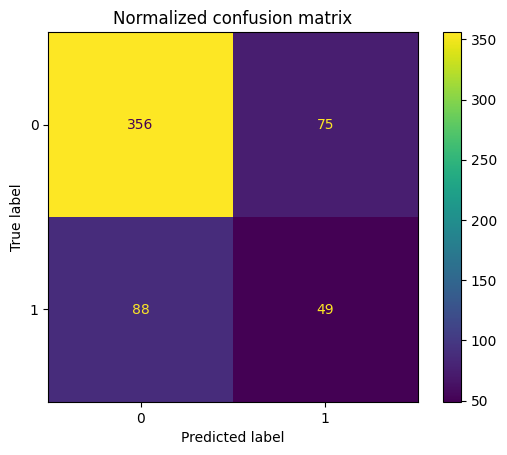

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       431
           1       0.40      0.36      0.38       137

    accuracy                           0.71       568
   macro avg       0.60      0.59      0.59       568
weighted avg       0.70      0.71      0.71       568



Done!


In [33]:
def model_assessment(model, X, y):

    # Get the confusion matrix.
    print("Confusion matrix:")
    #disp = plot_confusion_matrix(model, X, y,
    #                             cmap=plt.cm.Blues,
    #                             normalize='true')
    disp = ConfusionMatrixDisplay.from_estimator(model, X, y)
    disp.ax_.set_title("Normalized confusion matrix")

    plt.show()

    # Produce a classification report.
    print("Classification Report:")
    pred = model.predict(X)
    print(classification_report(y, pred))
    print('\n')
    print("Done!")

model_assessment(model, X_test, y_test)

### Counterfactuals

Finally, we can generate counterfactuals. This notebook will do it for the 12th observation from the test set.

We can define a function that would make it easy to generate multiple counterfactuals. It will be tailored to our model and data.
This function will also pre-define seven hyperparameter values that govern the behaviour of the algorithm used to generate counterfactuals.




In [36]:
def generate_cfs(model,
                 X,
                 beta = .01,
                 c_init = 1.,
                 c_steps = 10,
                 max_iterations = 5000,
                 use_kdtree = True,
                 theta = 100,
                 d_type = 'abdm'):

  # We can measure the time it takes to perform all the operations from taking our input to having the outputs.
  start = time.time()

  # Make sure the data is in the right format so that it can be used with
  # CounterFactualProto() from Alibi.
  #X = np.asmatrix(X.reshape((1,) + X.shape))
  X = X.reshape((1,) + X.shape)

  # Defining the shape of the instance to be explained.
  shape = X.shape

  # We need to specify the feature-wise min and max values that the algorithm will use.

  # The numerical features will be between -1 and 1 (as we have scaled them).
  # The categorical features will be either 0 and 1 (given one-hot encoding).
  maxes = []
  mins = []
  for col in df.columns.tolist()[::-1]:
    if col in numeric_features:
      maxes.append(1)
      mins.append(-1)
    else:
      maxes.append(1)
      mins.append(0)
  feature_range = ((np.array([mins])).astype(np.float32), (np.array([maxes])).astype(np.float32))

  # Define a function that finds probabilities for each class using our fitted model.
  predict_fn = lambda x: model.predict_proba(x)

  # Generate the counterfactual.
  cf = CounterfactualProto(predict_fn,
                          shape,
                          beta=beta,
                          theta=theta,
                          cat_vars=dictionary_onehot,
                          ohe=True,
                          use_kdtree=use_kdtree,
                          max_iterations=max_iterations,
                          feature_range=feature_range,
                          c_init=c_init,
                          c_steps=c_steps
                          )

  cf.fit(X_train, d_type = d_type)

  # Here is our counterfactual!
  # cf is a dictionary with the overall best counterfactual found
  explanation = cf.explain(X)
  generated_counterfactual = explanation.cf["X"]

  # Let's find the difference between our instance and the generated counterfactual.
  change = generated_counterfactual - X

  # We can now reshape the information to display it in a clear way.
  change = pd.DataFrame(change, columns=df_dummies.columns)
  change = change[change != 0].dropna(axis='columns')
  impacted_features = change.columns.tolist()
  impacted_values = change.values.tolist()[0]
  impacted_dict = dict(zip(impacted_features, impacted_values))

  original_values = pd.DataFrame(X, columns=df_dummies.columns)[impacted_features].values[0].tolist()
  original_dict = dict(zip(impacted_features, original_values))

  # Print the information we are looking for.
  print("Results:")
  print("---")
  print('Counterfactual prediction: {}'.format(explanation.cf['class']))
  print("---")
  print("If the following changes happen to the feature matrix:")
  print(impacted_dict)
  print("")
  print("The classifier will flip its prediction given the new class probabilities below:")
  print('- Class 0: {:.2f}'.format(explanation.cf["proba"].tolist()[0][0]))
  print('- Class 1: {:.2f}'.format(explanation.cf["proba"].tolist()[0][1]))
  print("---")
  print('Original prediction: {}'.format(model.predict(X)[0]))
  print("The classification probabilities assosciated with the original instance:")
  print('- Class 0: {:.2f}'.format(model.predict_proba(X)[0][0]))
  print('- Class 1: {:.2f}'.format(model.predict_proba(X)[0][1]))
  print("")
  print("Original values of the adjusted features:")
  print(original_dict)
  print("---")

  end = time.time()
  print('Counterfactual generation performed in {:.2f} seconds'.format(end - start))

  # Return two dictionaries:
  # - one that states what needs to change and by what margin
  # - one that provides the original values of the features that would need to change
  return impacted_dict, original_dict

We will run the function to generate counterfactuals for the the 12th sample from the test set.

In [37]:
cf_11, orig_11 = generate_cfs(model, X_test[11])

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_st

Results:
---
Counterfactual prediction: 0
---
If the following changes happen to the feature matrix:
{'Officer-defined ethnicity_Asian': -1.0, 'Officer-defined ethnicity_Other': 1.0}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.52
- Class 1: 0.48
---
Original prediction: 1
The classification probabilities assosciated with the original instance:
- Class 0: 0.32
- Class 1: 0.68

Original values of the adjusted features:
{'Officer-defined ethnicity_Asian': 1.0, 'Officer-defined ethnicity_Other': 0.0}
---
Counterfactual generation performed in 449.39 seconds



*NOTE: As the generation of counterfactuals is inherently stochastic, it is very likely your generated counterfactual will not be reflected in the following interpretation.*

The results can be interpreted in the following way:

*   The best counterfactual (one that is easy to interpret, reflects the distribution of the original dataset and "just push the new instance over the decision boundary" (i.e. lead to minimal changes in estimated probabilities while still changing the class)) has been found. In some cases, the algorithm may fail to find any "best" counterfactuals and any "if X had not happened, Y would not have happened" analyses need to be done manually. However, those may breach what in ML literature is considered an appropriate counterfactual.
*   This counterfactual states that if we changed the instance's gender status from "male" to "female, the model would classify it as being class 0 instead of 1.
*   This small alteration in the attributes would increase the probability of the observation being class 0 from 0.29 to 0.51.
*   In the context of our application, the algorithm would tell the police force to stop and search the given person if their gender was specified as male and not female.



Let's try generating counterfactuals for another person. For example that can be observation number 98 from the test set.

In [44]:
cf_98, orig_98 = generate_cfs(model, X_test[98])

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_st

Results:
---
Counterfactual prediction: 1
---
If the following changes happen to the feature matrix:
{'Longitude': 0.003643272677436471, 'Latitude': 0.0072029829025268555}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.43
- Class 1: 0.57
---
Original prediction: 0
The classification probabilities assosciated with the original instance:
- Class 0: 0.82
- Class 1: 0.18

Original values of the adjusted features:
{'Longitude': 0.0029811186250299215, 'Latitude': -0.15573278069496155}
---
Counterfactual generation performed in 516.81 seconds


In [45]:
cf_98

{'Longitude': 0.003643272677436471, 'Latitude': 0.0072029829025268555}

Let's also define a function that will scale the numerical features back.

In [46]:
def inv_transform_cols(val, feat_name):
  return ((val[feat_name] - scaling_factors_2[feat_name])/scaling_factors_1[feat_name])[0]

# Find the actual counterfactual example which will be the change values + the original values of the instance.
cf_example_98 = {}
cf_example_98["Latitude"] = cf_98["Latitude"] + orig_98["Latitude"]
cf_example_98["Longitude"] = cf_98["Longitude"] + orig_98["Longitude"]

# Apply the transformations.
print("Original values:")
print('- Longitude: {:.4}'.format(inv_transform_cols(orig_98, "Longitude")))
print('- Latitude: {:.4f}'.format(inv_transform_cols(orig_98, "Latitude")))
print("")
print("Counterfactual values:")
print('- Longitude: {:.4f}'.format(inv_transform_cols(cf_example_98, "Longitude")))
print('- Latitude: {:.4f}'.format(inv_transform_cols(cf_example_98, "Latitude")))

Original values:
- Longitude: -0.1161
- Latitude: 51.4598

Counterfactual values:
- Longitude: -0.1147
- Latitude: 51.4611


*NOTE: Again, your counterfactuals may suggest different feature changes so it is possible that the counterfactual values for longitude and latitude suggest a different location. It is also possible the selected counterfactual does not include changes to longitude and latitude.*

The original geolocation is south of Victoria Park in Bow, while the counterfactual value leads us to a place in west Kennington. This means that the model would classify the person as class 1 if their location was more to the south west of the real spot where they were stopped by the police.

#### **Question 4:**
Do you think that the generated counterfactuals are reasonable? Justify your view.

#### **Question 5:**
Try selecting different hyperparameter values inside CounterFactualProto() and re-running the code. Are the generated counterfactuals different from the previous generated instances?

---

## Assignment 2


1.   What are the issues with the idea of robo-police introduced above? Consider both societal impacts and algortithmic fairness considerations.
2.  Use the XGBoost ```predict_proba``` function to identify the instances that are close to the decision boundary, where prediction for class 0 is 50-53%, and instances far from the decision boundary, where prediction for class 0 is greater than 83% or 90%. Create two sets of these model-confident and model-uncertain points and select a single instance from each set. For both cases, generate counterfactuals, then compare the counterfactual explanations for the confident instance and the uncertain instance. What features are the same if any, and what can be inferred between the two counterfactuals in terms of features and the confidence of the model? *Hint: As your model performance may be different, feel free to adjust the prediction accuracy threshold in order to identify confident and uncertain instances.*
3.  Generate a counterfactual for observation X_test[101] and interpret the outputs.
4.  Use another ML model instead of XGBoost and generate a counterfactual instance for one of the observations in the introduction (X_test[99] or X_test[11]) and comment on the differences or similarities between the generated counterfactual.
5.  Select 3 instances close to the decision boundary, use the set of uncertain instances derived in Question 2. Generate counterfactuals for these three observations and comment on the features that were changed for them. Are there shared feature changes between observations and are there specific differences? What can broadly be inferred based on the counterfactual explanations of these three instances?
6.  Plot two SHAP dependence plots that show the relationship between the numerical features (longitude and latitude) based on the XGBoost model. So for each plot on one of the features, simply set the```interaction_index``` to the opposite feature. Can those graphs help us explain counterfactuals driven by geoinformation?

